<h2>Lead Scoring Case Study </h2>

<p>
<b>Problem Statement Simplified</b>
<p style="font-size:medium;text-align:justify">
An education company named <b> X Education</b> sells online courses to industry professionals, marketing on their own website, several other websites and search engines like Google. Currently <b>LEads</b> are generated by people filling up a form on the website (providing email address or phone number), and through past referrals as well. Sales team starts reaching out to these <b>Leads</b> and try to get them converted to as <b>Prospects</b> that would but the courses, for which the current <b> Lead Conversion Rate is around 30%</b>. For Example, if 100 Leads are acquired, 30 are converted</b>.

The Company wishes to identify the most Potential Leads also know as Hot Leads , so that the Lead Convertion Rate should go up as the sales team will now be communicating with the potential leads rather than reaching everyone. The CEO, in particular, has given the ballpark of the target lead conversion rate to be around 80%.
</p>
<b>Goal (Simplified)</b>
<p style="font-size:medium;text-align:justify">
A logistic Regression Model needs to built to assign a Lead Score between 0 to 100 , that higher the score the customer is likely to Convert (Hot Lead) and vice versa holds true.
</p>
</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

<h4>Start:User Defined Functions</b>

In [2]:
def importSourceData(filename):
    dfTemp=pd.read_csv(filename)
    return dfTemp

In [3]:
def checkColumnHasOutlier(dfInput,column_name):
    Q1=dfInput[column_name].quantile(0.25)
    Q3=dfInput[column_name].quantile(0.75)
    IQR=Q3-Q1
    IQRmin=Q1-(1.5*IQR)
    IQRmax=Q3+(1.5*IQR)
    dfLessThan=dfInput[dfInput[column_name]<IQRmin]
    dfGreaterThan=dfInput[dfInput[column_name]>IQRmax]
    return (dfLessThan.empty==False or dfGreaterThan.empty==False)

In [4]:
def getOutlierData(dfInput,lstColumns=None):
    dictOutliers=[]
    if lstColumns==None:
        lstColumns=dfInput.columns
    for column_name in lstColumns:
        _outlierItem={}
        Q1=dfInput[column_name].quantile(0.25)
        Q2=dfInput[column_name].quantile(0.5)
        Q3=dfInput[column_name].quantile(0.75)
        IQR=Q3-Q1
        IQRmin=Q1-(1.5*IQR)
        IQRmax=Q3+(1.5*IQR)
        dfLessThan=dfInput[dfInput[column_name]<IQRmin]
        dfGreaterThan=dfInput[dfInput[column_name]>IQRmax]
        hasOutlier=(dfLessThan.empty==False or dfGreaterThan.empty==False)
        if hasOutlier==True:
            _outlierItem['column_name']=column_name
            _outlierItem['rows']=dfInput[column_name].count()
            _outlierItem['min']=dfInput[column_name].min()
            _outlierItem['max']=dfInput[column_name].max()
            _outlierItem['Q1(0.25)']=Q1
            _outlierItem['Q2(0.5)']=Q2
            _outlierItem['Q3(0.75)']=Q3
            _outlierItem['IQR']=IQR
            _outlierItem['IQRmin']=IQRmin
            _outlierItem['IQRmax']=IQRmax
            _outlierItem['<IQRmin']=dfLessThan.shape[0]
            _outlierItem['>IQRmax']=dfGreaterThan.shape[0]
            dictOutliers.append(_outlierItem)
    dfReturn=pd.DataFrame.from_dict(dictOutliers)
    return dfReturn


In [5]:
def getNullColumns(dfInput, exporttocsv=False,filename='nullcolumns.csv'):
    null_count=dfInput.isnull().sum()
    null_percentage=100.0*dfInput.isnull().sum()/len(dfInput.index)
    dfFinal=pd.DataFrame({'column_name':dfInput.columns,'null_count':null_count,'null_percentage':null_percentage,'dtype':dfInput.dtypes}).reset_index()
    for idx,row in dfFinal.iterrows():
        column_name=row['column_name']
        data_type=row['dtype']
        if data_type in ['float64','int64']:
            dfFinal['HasOutlier']=checkColumnHasOutlier(dfInput,column_name)
        else:
            dfFinal['HasOutlier']='False'
    if exporttocsv==True:
        dfFinal.to_csv(filename,index=False)
    dfFinal=dfFinal.drop('column_name',axis=1)
    dfFinal=dfFinal.rename({'index':'column_name'},axis=1)
    dfFinal=dfFinal[dfFinal['null_percentage']>0]
    dfFinal=dfFinal.sort_values(by='null_count',ascending=False).reset_index(drop=True)
    return dfFinal

In [6]:
def getValueCountsOfColumns(dfInfo,dfInput,export=False,filename='value_counts.csv'):
    if type(dfInfo) is list:
        dfInfo=pd.DataFrame(dfInfo).reset_index(drop=True)
        dfInfo.columns=["column_name"]
    dfFinalValue_Counts=[]
    for idx,row in dfInfo.iterrows():
        column_name=row["column_name"]
        dfTemp=pd.DataFrame(round(dfInput[column_name].value_counts(normalize=True)*100.0,2)).reset_index()
        dfTemp.columns=["column_values",'value_percentage']
        dfTemp.insert(0,"column_name",column_name)
        dfFinalValue_Counts.append(dfTemp)
    dfFinal=pd.concat(dfFinalValue_Counts,axis=0)
    if export==True:
        dfFinal.to_csv(filename,index=False)
    return dfFinal
        

In [7]:
def replaceColumnValue(dfInput,column_name,findValue,replaceValue):
    dfInput[column_name]=dfInput[column_name].replace(findValue,replaceValue)
    return dfInput

In [8]:
def replaceSpecificColumnValueWithNull(dfInput,column_name,findValue):
    for column_name in dfInput.columns:
        dfInput=replaceColumnValue(dfInput,column_name,findValue,np.nan)
    return dfInput

In [9]:
def getColumnsByType(dfInput,column_type,exclude=False):
    lstColumns=[]
    column_type=column_type.strip().lower()
    dft=pd.DataFrame(dfInput.dtypes).reset_index()
    dft.columns=['column_name','dtype']
    if column_type=='numeric':
        lstColumns=list(dft[(dft['dtype']=='float64')|(dft['dtype']=='int64')]['column_name'])
    elif column_type=='categorical':
        lstColumns=list(dft[dft['dtype']=='object']['column_name'])
    return lstColumns

        

In [10]:
def getColumnsWithYesNoValue(dfInput):
    dfColumnsValueCounts=getValueCountsOfColumns(list(dfInput.columns),dfInput)
    lstColumnsForYesNoReplacement=list(dfColumnsValueCounts[(dfColumnsValueCounts['column_values'].str.lower()=='yes')|(dfColumnsValueCounts['column_values'].str.lower()=='no')]['column_name'].unique())
    return lstColumnsForYesNoReplacement

In [11]:
def drawboxplots(_suptitle,_dataSource,_xcolumnsList,_yColumn=None,_hueColumn=None, figsizeX=10, figsizeY=10,rows=3,cols=3,_orient='v'):
    plt.figure(figsize=(figsizeX, figsizeY))
    f,axes=plt.subplots(rows,cols,squeeze=False)
    rowIndex=0
    columnIndex=0
    for _column in _xcolumnsList:
        sns.boxplot(x=_column, data=_dataSource,y=_yColumn,hue=_hueColumn, orient=_orient, ax=axes[rowIndex][columnIndex])
        columnIndex=columnIndex+1
        if columnIndex>(cols-1):
            columnIndex=0
            rowIndex=rowIndex+1
        if rowIndex>(rows-1):
           break 


    f.tight_layout()
    f.suptitle(_suptitle)
    f.subplots_adjust(top=0.88)
    plt.show()   

<h4>End:User Defined Functions</b>


<h3>Step 1: Reading and Understanding Data</h3>

In [12]:
dfSource=importSourceData('Leads.csv')
dfSource.shape

(9240, 37)

In [13]:
#quick check using dropna 
print("before drop na", dfSource.shape)
dfTempCheck= dfSource.dropna(axis=0)
print("after drop na", dfTempCheck.shape)


before drop na (9240, 37)
after drop na (1943, 37)


<h3>Step-2 EDA</h3>

<h4>EDA-Steps</h4>
<ol>
<li>Replace Lengthy column names with meaningful and shorter column names, replacing space(s) with underscore(s)</li>
<li>Identify all Columns with 'Select' values and replace with null, as 'Select' is default value from UI Dropdown</li>
<li>Impute Null Values, drop few unwanted columns </li>
<li>Identify all Columns with 'Yes/No' values and replace with 1/0 respectively</li>
<li>Group the Values of Categorical Columns through Value Translations</li>
<li>Create Dummy Variables</li>
<li>Drop the Duplicate Categorical Columns and any other unwanted columns (if any)</li>
<li>Find and remove Outliers</li>
</ol>

<h4>Step-2.1 Rename Columns</h4>

In [14]:
columnRenameMap={'What matters most to you in choosing a course':'Course_Reason',
    'What is your current occupation':'Occupation',
    'How did you hear about X Education':'Marketing_Source',
    'Asymmetrique Activity Index':'Activity_Index',
    'Asymmetrique Activity Score':'Activity_Score',
    'Asymmetrique Profile Index':'Profile_Index',
    'Asymmetrique Profile Score':'Profile_Score',
    'Update me on Supply Chain Content':'Supply_Chain_Content',
    'Get updates on DM Content':'DM_Content',
    'I agree to pay the amount through cheque':'cheque_payment',
    'Receive More Updates About Our Courses':'More_Updates',
    'Total Time Spent on Website':'Website_Time_Spent',
    'Page Views Per Visit':'PVPV',
    'TotalVisits':'Total_Visits',
    'A free copy of Mastering The Interview':'Free_Copy'
}
dfSource=dfSource.rename(columns=columnRenameMap)
#Rename Columns that has spaces with Underscore
dfSource.columns=dfSource.columns.str.replace(' ','_')
dfSource.columns





Index(['Prospect_ID', 'Lead_Number', 'Lead_Origin', 'Lead_Source',
       'Do_Not_Email', 'Do_Not_Call', 'Converted', 'Total_Visits',
       'Website_Time_Spent', 'PVPV', 'Last_Activity', 'Country',
       'Specialization', 'Marketing_Source', 'Occupation', 'Course_Reason',
       'Search', 'Magazine', 'Newspaper_Article', 'X_Education_Forums',
       'Newspaper', 'Digital_Advertisement', 'Through_Recommendations',
       'More_Updates', 'Tags', 'Lead_Quality', 'Supply_Chain_Content',
       'DM_Content', 'Lead_Profile', 'City', 'Activity_Index', 'Profile_Index',
       'Activity_Score', 'Profile_Score', 'cheque_payment', 'Free_Copy',
       'Last_Notable_Activity'],
      dtype='object')

<h4>Handle Columns with 'Select' Values</h4>

In [15]:
#1.Get all Columns with 'Select' as one of the Values
def getColumnsWithSelectValues(dfInput):
    dfValueCountsOfColumns=getValueCountsOfColumns(list(dfInput),dfInput)
    lstColumnsWithSelectValues=list(dfValueCountsOfColumns[dfValueCountsOfColumns['column_values']=='Select']['column_name'].unique())
    return lstColumnsWithSelectValues
lstColumnsWithSelectValues=getColumnsWithSelectValues(dfSource)
print("Columns with 'Select' values",lstColumnsWithSelectValues)
#output: ['Specialization', 'Marketing_Source', 'Lead_Profile', 'City']
#2.Replace 'Select' with np.nan usiing the User Defined Function 
dfSource=replaceSpecificColumnValueWithNull(dfSource,lstColumnsWithSelectValues,'Select')
lstColumnsWithSelectValues=getColumnsWithSelectValues(dfSource)
print("Reverification : No Columns with 'Select' VaLues",lstColumnsWithSelectValues)


Columns with 'Select' values ['Specialization', 'Marketing_Source', 'Lead_Profile', 'City']
Reverification : No Columns with 'Select' VaLues []


<h4>Drop Few Columns </h4>

In [16]:
dfSource=dfSource.drop(['Lead_Number','Prospect_ID','Country','City'],axis=1)

In [17]:
#1.Get Null Columns through the User Defined Function
getNullColumns(dfSource)

,column_name,null_count,null_percentage,dtype,HasOutlier
0,Marketing_Source,7250,78.463203,object,False
1,Lead_Profile,6855,74.188312,object,False
2,Lead_Quality,4767,51.590909,object,False
3,Activity_Index,4218,45.649351,object,False
4,Profile_Index,4218,45.649351,object,False
5,Activity_Score,4218,45.649351,float64,False
6,Profile_Score,4218,45.649351,float64,False
7,Specialization,3380,36.580087,object,False
8,Tags,3353,36.287879,object,False
9,Course_Reason,2709,29.318182,object,False


<h4>Remove columns with null_count>3000</h4>

In [18]:

for col in dfSource.columns:
    if dfSource[col].isnull().sum() > 3000:
        dfSource.drop(col, axis=1, inplace=True)

<h4>Replace columns with Yes/No values with 1/0 respectively through User Defined Function</h4>

In [19]:
lstYesNoBeforeReplacement=getColumnsWithYesNoValue(dfSource)
print("Yes/No columns before replacement",lstYesNoBeforeReplacement)
for column_name in lstYesNoBeforeReplacement:
    dfSource[column_name]=dfSource[column_name].apply(lambda x:x.lower())
    dfSource[column_name]=dfSource[column_name].map({'yes':1,'no':0})
    dfSource[column_name]=dfSource[column_name].astype(int)
lstYesNoAfterReplacement=getColumnsWithYesNoValue(dfSource)
print("Yes/No columns after replacement",lstYesNoAfterReplacement)


Yes/No columns before replacement ['Do_Not_Email', 'Do_Not_Call', 'Search', 'Magazine', 'Newspaper_Article', 'X_Education_Forums', 'Newspaper', 'Digital_Advertisement', 'Through_Recommendations', 'More_Updates', 'Supply_Chain_Content', 'DM_Content', 'cheque_payment', 'Free_Copy']
Yes/No columns after replacement []


<h4>Drop 1/0 columns that has only 0 as value</h4>

In [20]:
dfValueCountsYesNo=getValueCountsOfColumns(lstYesNoBeforeReplacement,dfSource)
dfZeroColumns=dfValueCountsYesNo[(dfValueCountsYesNo['value_percentage']==100)&(dfValueCountsYesNo['column_values']==0)]
dfZeroColumns


,column_name,column_values,value_percentage
0,Magazine,0,100.0
0,More_Updates,0,100.0
0,Supply_Chain_Content,0,100.0
0,DM_Content,0,100.0
0,cheque_payment,0,100.0


In [21]:
print("before drop",dfSource.shape)
lstDropColumns=dfZeroColumns["column_name"].unique()
print("Columns to be dropped=",lstDropColumns)
dfSource=dfSource.drop(lstDropColumns,axis=1)
print("after drop",dfSource.shape)


before drop (9240, 24)
Columns to be dropped= ['Magazine' 'More_Updates' 'Supply_Chain_Content' 'DM_Content'
 'cheque_payment']
after drop (9240, 19)


<h5>Get Value Counts of Categorical Columns</h5>

In [22]:
categoricalColumns=getColumnsByType(dfSource,'categorical')
dfValueCounts=getValueCountsOfColumns(categoricalColumns,dfSource,True,'categorical_columns.csv')
dfCountOfColumnValues=pd.DataFrame(dfValueCounts.groupby(by='column_name')['column_values'].agg('count')).reset_index()
dfCountOfColumnValues.columns=['column_name','count_of_values']
dfColumnInfo=dfCountOfColumnValues.sort_values(['count_of_values'],ascending=True)
list(dfColumnInfo['column_name'].unique())

['Course_Reason',
 'Lead_Origin',
 'Occupation',
 'Last_Notable_Activity',
 'Last_Activity',
 'Lead_Source']

<h3>Creating Dummy Variables</h3> 

In [23]:
dict_columndefinitions=[
 {'col_name':'Course_Reason','col_prefix':'COURSE_REASON'},
 {'col_name':'Lead_Origin','col_prefix':'LD_ORIGIN'},
 {'col_name':'Occupation','col_prefix':'OCCU'},
 {'col_name':'Last_Notable_Activity','col_prefix':'LST_NTB_ACT'},
 {'col_name':'Last_Activity','col_prefix':'LST_ACT'},
 {'col_name':'Lead_Source','col_prefix':'LD_SRC'}
 ]

for currentDef in dict_columndefinitions:
    col_name=currentDef['col_name']
    col_prefix=currentDef['col_prefix']
    #Creating the dummyVariables Dynamically using globals() function
    dummyVariableName='dummy__'+col_prefix
    globals()[dummyVariableName]=pd.get_dummies(dfSource[col_name],prefix=col_prefix,dtype=int,drop_first=True,dummy_na=True)
    dfSource=pd.concat([dfSource,globals()[dummyVariableName]],axis=1)


In [24]:
#Verification of dummy variables Creation
for currentDef in dict_columndefinitions:
    col_name=currentDef['col_name']
    col_prefix=currentDef['col_prefix']
    dummyVariableName='dummy__'+col_prefix
    print(globals()[dummyVariableName].head(5))


   COURSE_REASON_Flexibility & Convenience  COURSE_REASON_Other  \
0                                        0                    0   
1                                        0                    0   
2                                        0                    0   
3                                        0                    0   
4                                        0                    0   

   COURSE_REASON_nan  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
   LD_ORIGIN_Landing Page Submission  LD_ORIGIN_Lead Add Form  \
0                                  0                        0   
1                                  0                        0   
2                                  1                        0   
3                                  1                        0   
4                                  1                        0   

   LD_ORIGIN_Lead Import  LD_ORIGIN_Quick Add Form  LD_ORIGIN_nan  


<b>Drop the Repeated Categorical Column<b>

In [25]:
categoricalColumns=getColumnsByType(dfSource,'categorical') #get the categorical columns list using the User Defined Function
print('categorical columns before drop ',categoricalColumns)
dfSource=dfSource.drop(categoricalColumns,axis=1)
categoricalColumns=getColumnsByType(dfSource,'categorical') #get the categorical columns again to confirm if its dropped.
print('categorical columns after drop ',categoricalColumns)


categorical columns before drop  ['Lead_Origin', 'Lead_Source', 'Last_Activity', 'Occupation', 'Course_Reason', 'Last_Notable_Activity']
categorical columns after drop  []


<b>Drop the Dummy Columns with _nan (if any)<b>

In [26]:
lstNaNColumns=dfSource.columns[dfSource.columns.str.contains("_nan")] #get all (dummy variable) columns that has _nan (columns with null values only)
print("_nan columns before drop:",list(lstNaNColumns))
dfSource=dfSource.drop(lstNaNColumns,axis=1)
lstNaNColumns=dfSource.columns[dfSource.columns.str.contains("_nan")] #reverification
print("_nan columns after drop:",list(lstNaNColumns))


_nan columns before drop: ['COURSE_REASON_nan', 'LD_ORIGIN_nan', 'OCCU_nan', 'LST_NTB_ACT_nan', 'LST_ACT_nan', 'LD_SRC_nan']
_nan columns after drop: []


<H4>Handling Outliers for Continuous Variable Columns</h4>

In [27]:
lstContinuousVariableColumns=['Total_Visits',
 'Website_Time_Spent',
 'PVPV']

getOutlierData(dfSource,lstContinuousVariableColumns)

,column_name,rows,min,max,Q1(0.25),Q2(0.5),Q3(0.75),IQR,IQRmin,IQRmax,<IQRmin,>IQRmax
0,Total_Visits,9103,0.0,251.0,1.0,3.0,5.0,4.0,-5.0,11.0,0,267
1,PVPV,9103,0.0,55.0,1.0,2.0,3.0,2.0,-2.0,6.0,0,360


<b>Check OUtlier Graphically</b>

<Figure size 8000x3000 with 0 Axes>

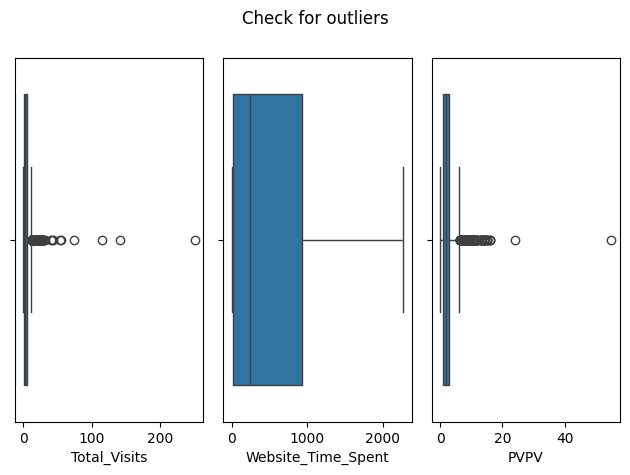

In [28]:
drawboxplots("Check for outliers",dfSource,lstContinuousVariableColumns,figsizeX=80,figsizeY=30,rows=1,cols=3)

In [29]:
#Removal of Outlier values
dfSource=dfSource[dfSource['Total_Visits']<=40] #Removing outliers from Total_Visits column taking 50 as cut off value
dfSource=dfSource[dfSource['PVPV']<=22] #Removing outliers from Pages Viewed Per Visit, taking 50 as cut off value


<Figure size 8000x3000 with 0 Axes>

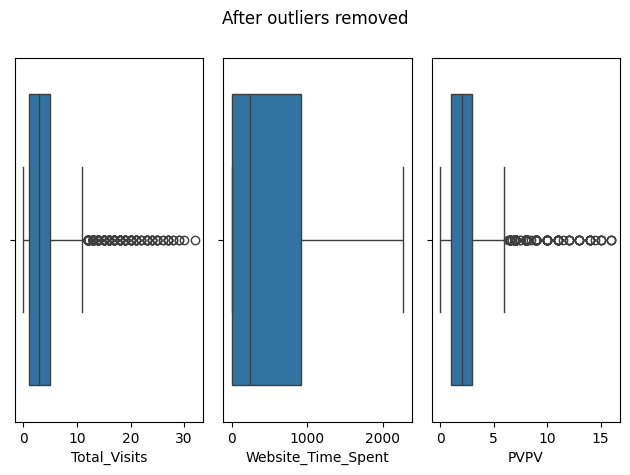

In [30]:
drawboxplots("After outliers removed",dfSource,lstContinuousVariableColumns,figsizeX=80,figsizeY=30,rows=1,cols=3)


<b>Completed EDA Steps up to here, proceeding with Test Train Split</b>

<h3>Step 3: Test Train Split</h3>

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X=dfSource.drop(['Converted'],axis=1)
X.head()

,Do_Not_Email,Do_Not_Call,Total_Visits,Website_Time_Spent,PVPV,Search,Newspaper_Article,X_Education_Forums,Newspaper,Digital_Advertisement,...,LD_SRC_Referral Sites,LD_SRC_Social Media,LD_SRC_WeLearn,LD_SRC_Welingak Website,LD_SRC_bing,LD_SRC_blog,LD_SRC_google,LD_SRC_testone,LD_SRC_welearnblog_Home,LD_SRC_youtubechannel
0,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2.0,1532,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2.0,1428,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y=dfSource["Converted"]
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)
X_train.head()

,Do_Not_Email,Do_Not_Call,Total_Visits,Website_Time_Spent,PVPV,Search,Newspaper_Article,X_Education_Forums,Newspaper,Digital_Advertisement,...,LD_SRC_Referral Sites,LD_SRC_Social Media,LD_SRC_WeLearn,LD_SRC_Welingak Website,LD_SRC_bing,LD_SRC_blog,LD_SRC_google,LD_SRC_testone,LD_SRC_welearnblog_Home,LD_SRC_youtubechannel
9044,0,0,7.0,1524,1.4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3022,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6232,0,0,5.0,472,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309,0,0,5.0,263,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3833,0,0,4.0,298,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X_train[['Total_Visits', 'Website_Time_Spent', 'PVPV']].head()

,Total_Visits,Website_Time_Spent,PVPV
9044,7.0,1524,1.4
3022,0.0,0,0.0
6232,5.0,472,5.0
309,5.0,263,2.5
3833,4.0,298,4.0


<h3>Step 4: Scaling - Min Max</h3>

In [36]:
# Scale the three numeric features present in the dataset - 'Total_Visits', 'Website_Time_Spent', 'PVPV(Page Views Per Visit)'
from sklearn.preprocessing import MinMaxScaler
numeric_columns=['Total_Visits', 'Website_Time_Spent', 'PVPV']
scaler_minmax = MinMaxScaler()
X_train[numeric_columns] = scaler_minmax.fit_transform(X_train[numeric_columns])


In [37]:
X_train[['Total_Visits', 'Website_Time_Spent', 'PVPV']].head()


,Total_Visits,Website_Time_Spent,PVPV
9044,0.21875,0.670775,0.08750
3022,0.00000,0.000000,0.00000
6232,0.15625,0.207746,0.31250
309,0.15625,0.115757,0.15625
3833,0.12500,0.131162,0.25000


<b>Correlation</b>

In [38]:
dfSource.corr()

,Do_Not_Email,Do_Not_Call,Converted,Total_Visits,Website_Time_Spent,PVPV,Search,Newspaper_Article,X_Education_Forums,Newspaper,...,LD_SRC_Referral Sites,LD_SRC_Social Media,LD_SRC_WeLearn,LD_SRC_Welingak Website,LD_SRC_bing,LD_SRC_blog,LD_SRC_google,LD_SRC_testone,LD_SRC_welearnblog_Home,LD_SRC_youtubechannel
Do_Not_Email,1.000000,-0.004343,-0.135345,0.002491,-0.048802,0.022302,-0.011498,-0.004343,-0.003071,-0.003071,...,-0.013105,-0.004343,-0.003071,0.002807,-0.007524,-0.003071,0.010528,-0.003071,-0.003071,0.035818
Do_Not_Call,-0.004343,1.000000,0.018930,0.004950,0.007072,-0.006093,-0.000582,-0.000220,-0.000156,-0.000156,...,-0.001737,-0.000220,-0.000156,-0.001779,-0.000381,-0.000156,-0.000348,-0.000156,-0.000156,-0.000156
Converted,-0.135345,0.018930,1.000000,0.045645,0.355378,-0.001688,-0.001881,0.003654,-0.008217,-0.008217,...,-0.030963,0.003654,0.013385,0.149270,-0.011313,-0.008217,-0.018379,-0.008217,-0.008217,-0.008217
Total_Visits,0.002491,0.004950,0.045645,1.000000,0.313603,0.678339,0.071232,0.048242,0.050946,0.020336,...,0.074508,-0.003709,-0.004153,-0.109931,-0.008925,0.001969,0.015359,0.005030,-0.004153,0.001969
Website_Time_Spent,-0.048802,0.007072,0.355378,0.313603,1.000000,0.332044,0.013300,0.011658,0.006405,0.025610,...,0.012127,0.001956,0.013525,-0.091602,-0.010159,0.003769,0.003222,-0.003408,-0.002177,0.000113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LD_SRC_blog,-0.003071,-0.000156,-0.008217,0.001969,0.003769,0.008332,-0.000412,-0.000156,-0.000110,-0.000110,...,-0.001228,-0.000156,-0.000110,-0.001258,-0.000269,1.000000,-0.000246,-0.000110,-0.000110,-0.000110
LD_SRC_google,0.010528,-0.000348,-0.018379,0.015359,0.003222,0.020897,-0.000921,-0.000348,-0.000246,-0.000246,...,-0.002747,-0.000348,-0.000246,-0.002814,-0.000603,-0.000246,1.000000,-0.000246,-0.000246,-0.000246
LD_SRC_testone,-0.003071,-0.000156,-0.008217,0.005030,-0.003408,0.000748,-0.000412,-0.000156,-0.000110,-0.000110,...,-0.001228,-0.000156,-0.000110,-0.001258,-0.000269,-0.000110,-0.000246,1.000000,-0.000110,-0.000110
LD_SRC_welearnblog_Home,-0.003071,-0.000156,-0.008217,-0.004153,-0.002177,-0.001780,-0.000412,-0.000156,-0.000110,-0.000110,...,-0.001228,-0.000156,-0.000110,-0.001258,-0.000269,-0.000110,-0.000246,-0.000110,1.000000,-0.000110


<h3>Step 5: Model Building</h3>

In [39]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

<b>Feature Selection</b>

In [40]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg,n_features_to_select=15)             # running RFE with 15 variables as output , 
rfe = rfe.fit(X_train, y_train)

In [41]:
# Let's take a look at which features have been selected by RFE
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do_Not_Email', True, 1),
 ('Do_Not_Call', False, 20),
 ('Total_Visits', True, 1),
 ('Website_Time_Spent', True, 1),
 ('PVPV', True, 1),
 ('Search', False, 23),
 ('Newspaper_Article', False, 31),
 ('X_Education_Forums', False, 47),
 ('Newspaper', False, 17),
 ('Digital_Advertisement', False, 32),
 ('Through_Recommendations', False, 41),
 ('Free_Copy', False, 55),
 ('COURSE_REASON_Flexibility & Convenience', False, 18),
 ('COURSE_REASON_Other', False, 53),
 ('LD_ORIGIN_Landing Page Submission', False, 43),
 ('LD_ORIGIN_Lead Add Form', True, 1),
 ('LD_ORIGIN_Lead Import', False, 40),
 ('LD_ORIGIN_Quick Add Form', False, 57),
 ('OCCU_Housewife', True, 1),
 ('OCCU_Other', False, 3),
 ('OCCU_Student', False, 4),
 ('OCCU_Unemployed', False, 5),
 ('OCCU_Working Professional', True, 1),
 ('LST_NTB_ACT_Email Bounced', False, 21),
 ('LST_NTB_ACT_Email Link Clicked', True, 1),
 ('LST_NTB_ACT_Email Marked Spam', False, 26),
 ('LST_NTB_ACT_Email Opened', True, 1),
 ('LST_NTB_ACT_Email Received', 

In [42]:
col_RFE = X_train.columns[rfe.support_]
col_RFE

Index(['Do_Not_Email', 'Total_Visits', 'Website_Time_Spent', 'PVPV',
       'LD_ORIGIN_Lead Add Form', 'OCCU_Housewife',
       'OCCU_Working Professional', 'LST_NTB_ACT_Email Link Clicked',
       'LST_NTB_ACT_Email Opened', 'LST_NTB_ACT_Modified',
       'LST_NTB_ACT_Olark Chat Conversation',
       'LST_NTB_ACT_Page Visited on Website', 'LST_ACT_Converted to Lead',
       'LST_ACT_Email Bounced', 'LD_SRC_Welingak Website'],
      dtype='object')

In [43]:
# Select only the columns selected by RFE
X_train = X_train[col_RFE]

In [44]:
X_train.shape

(6365, 15)

<b>Assessing the Model with StatsModels</b>

In [45]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6349
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2706.8
Date:                Tue, 19 Nov 2024   Deviance:                       5413.5
Time:                        15:08:15   Pearson chi2:                 6.71e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3825
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2031      0.084     -2.408      0.016      -0.368      -0.038
Do_Not_Email                           -1.4147      0.197     -7.197      0.000      -1.800      -1.029
Total_Visits                            1.8436      0.411      4.486      0.000       1.038       2.649
Website_Time_Spent                      4.1062      0.152     27.076      0.000       3.809       4.403
PVPV                                   -2.7525      0.368     -7.472      0.000      -3.474      -2.031
LD_ORIGIN_Lead Add Form                 3.4879      0.218     15.968      0.000       3.060       3.916
OCCU_Housewife                         22.9084   1.58e+04      0.001      0.999    -3.1e+04    3.11e+04
OCCU_Working Professional               2.7767      0.188     14.758      0.000       2.408       3.145
LST_NTB_ACT_Email Link Clicked         -1.9100      0.255     -7.487      0.000      -2.410      -1.410
LST_NTB_ACT_Email Opened               -1.4362      0.087    -16.481      0.000      -1.607      -1.265
LST_NTB_ACT_Modified                   -1.9506      0.094    -20.734      0.000      -2.135      -1.766
LST_NTB_ACT_Olark Chat Conversation    -2.6764      0.336     -7.959      0.000      -3.335      -2.017
LST_NTB_ACT_Page Visited on Website    -1.9869      0.211     -9.415      0.000      -2.401      -1.573
LST_ACT_Converted to Lead              -1.0907      0.214     -5.085      0.000      -1.511      -0.670
LST_ACT_Email Bounced                  -1.3370      0.398     -3.355      0.001      -2.118      -0.556
LD_SRC_Welingak Website                 2.5411      1.033      2.460      0.014       0.517       4.566
=======================================================================================================
"""

<b>Dropping Occu_Houseiwife but before that let us check the VIF</b>

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor      

In [47]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
3,PVPV,4.16
1,Total_Visits,3.93
2,Website_Time_Spent,1.92
0,Do_Not_Email,1.82
13,LST_ACT_Email Bounced,1.77
9,LST_NTB_ACT_Modified,1.57
8,LST_NTB_ACT_Email Opened,1.44
4,LD_ORIGIN_Lead Add Form,1.43
14,LD_SRC_Welingak Website,1.29
12,LST_ACT_Converted to Lead,1.18


<b>VIF are well within threshold so dropping 'OCCU_Housewife' column</b>

In [48]:
#Dropping Profile_Score
column_name='OCCU_Housewife'
X_train.drop(column_name, axis=1, inplace=True)
X_test.drop(column_name, axis=1, inplace=True)

<b>VIF is well within threshold of 5</b>

In [49]:
# Refit the model with the new set of features

logm3 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2712.6
Date:                Tue, 19 Nov 2024   Deviance:                       5425.1
Time:                        15:08:16   Pearson chi2:                 6.72e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3813
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2034      0.084     -2.412      0.016      -0.369      -0.038
Do_Not_Email                           -1.4165      0.197     -7.206      0.000      -1.802      -1.031
Total_Visits                            1.8363      0.411      4.470      0.000       1.031       2.641
Website_Time_Spent                      4.1087      0.152     27.116      0.000       3.812       4.406
PVPV                                   -2.7486      0.368     -7.468      0.000      -3.470      -2.027
LD_ORIGIN_Lead Add Form                 3.4982      0.218     16.030      0.000       3.071       3.926
OCCU_Working Professional               2.7725      0.188     14.736      0.000       2.404       3.141
LST_NTB_ACT_Email Link Clicked         -1.8982      0.254     -7.486      0.000      -2.395      -1.401
LST_NTB_ACT_Email Opened               -1.4314      0.087    -16.436      0.000      -1.602      -1.261
LST_NTB_ACT_Modified                   -1.9441      0.094    -20.689      0.000      -2.128      -1.760
LST_NTB_ACT_Olark Chat Conversation    -2.6763      0.336     -7.958      0.000      -3.335      -2.017
LST_NTB_ACT_Page Visited on Website    -1.9860      0.211     -9.411      0.000      -2.400      -1.572
LST_ACT_Converted to Lead              -1.0972      0.214     -5.117      0.000      -1.517      -0.677
LST_ACT_Email Bounced                  -1.3378      0.398     -3.359      0.001      -2.119      -0.557
LD_SRC_Welingak Website                 2.5272      1.033      2.447      0.014       0.503       4.552
=======================================================================================================
"""

In [50]:
X_train.head()

,Do_Not_Email,Total_Visits,Website_Time_Spent,PVPV,LD_ORIGIN_Lead Add Form,OCCU_Working Professional,LST_NTB_ACT_Email Link Clicked,LST_NTB_ACT_Email Opened,LST_NTB_ACT_Modified,LST_NTB_ACT_Olark Chat Conversation,LST_NTB_ACT_Page Visited on Website,LST_ACT_Converted to Lead,LST_ACT_Email Bounced,LD_SRC_Welingak Website
9044,0,0.21875,0.670775,0.08750,0,0,0,1,0,0,0,0,0,0
3022,0,0.00000,0.000000,0.00000,1,0,0,0,0,0,0,0,0,0
6232,0,0.15625,0.207746,0.31250,0,0,0,1,0,0,0,0,0,0
309,0,0.15625,0.115757,0.15625,0,0,0,1,0,0,0,0,0,0
3833,0,0.12500,0.131162,0.25000,0,0,0,0,0,0,0,0,0,0


#Regenerating model to check value significance

In [51]:
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res=logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2712.6
Date:                Tue, 19 Nov 2024   Deviance:                       5425.1
Time:                        15:08:16   Pearson chi2:                 6.72e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3813
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2034      0.084     -2.412      0.016      -0.369      -0.038
Do_Not_Email                           -1.4165      0.197     -7.206      0.000      -1.802      -1.031
Total_Visits                            1.8363      0.411      4.470      0.000       1.031       2.641
Website_Time_Spent                      4.1087      0.152     27.116      0.000       3.812       4.406
PVPV                                   -2.7486      0.368     -7.468      0.000      -3.470      -2.027
LD_ORIGIN_Lead Add Form                 3.4982      0.218     16.030      0.000       3.071       3.926
OCCU_Working Professional               2.7725      0.188     14.736      0.000       2.404       3.141
LST_NTB_ACT_Email Link Clicked         -1.8982      0.254     -7.486      0.000      -2.395      -1.401
LST_NTB_ACT_Email Opened               -1.4314      0.087    -16.436      0.000      -1.602      -1.261
LST_NTB_ACT_Modified                   -1.9441      0.094    -20.689      0.000      -2.128      -1.760
LST_NTB_ACT_Olark Chat Conversation    -2.6763      0.336     -7.958      0.000      -3.335      -2.017
LST_NTB_ACT_Page Visited on Website    -1.9860      0.211     -9.411      0.000      -2.400      -1.572
LST_ACT_Converted to Lead              -1.0972      0.214     -5.117      0.000      -1.517      -0.677
LST_ACT_Email Bounced                  -1.3378      0.398     -3.359      0.001      -2.119      -0.557
LD_SRC_Welingak Website                 2.5272      1.033      2.447      0.014       0.503       4.552
=======================================================================================================
"""

<p> P-values are well within limit so moving on to Model Evaluation</p>

<h3>Step 6: Model Evaluation</h3>

In [52]:
# Use 'predict' to predict the probabilities on the train set

y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred[:10]

9044    0.782856
3022    0.964252
6232    0.205338
309     0.213871
3833    0.469510
1050    0.526410
5239    0.163173
4708    0.990916
6927    0.429820
8596    0.947531
dtype: float64

In [53]:
# Reshaping it into an array

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.78285574, 0.96425151, 0.205338  , 0.21387141, 0.46950971,
       0.52641039, 0.16317347, 0.99091582, 0.42982003, 0.94753135])

<b>Creating a dataframe with the actual conversion flag and the predicted probabilities</b>


In [54]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['ProspectID'] = y_train.index
y_train_pred_final.head()


,Converted,Conversion_Prob,ProspectID
0,1,0.782856,9044
1,1,0.964252,3022
2,0,0.205338,6232
3,1,0.213871,309
4,0,0.469510,3833


<b>Creating new column 'Predicted' with 1 if Conversion_Prob > 0.5 else 0<b>


In [55]:
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
# Let's take a look at the head
y_train_pred_final.head()


,Converted,Conversion_Prob,ProspectID,Predicted
0,1,0.782856,9044,1
1,1,0.964252,3022,1
2,0,0.205338,6232,0
3,1,0.213871,309,0
4,0,0.469510,3833,0


<b>Evaluate Model using Confusion Matrix</b>

In [56]:
from sklearn import metrics

In [57]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3462  455]
 [ 813 1635]]


In [58]:
#Checking Overall Accuracy
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))


0.8007855459544383


<b>Evaluating Other Metrics: Sensitivity, Specificity</b>

In [59]:
# Evaluating the other metrics:

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

metric_sensitivity=TP/(TP+FN)
metric_specificity=TN/(TN+FP)
print("metric_sensitivity",metric_sensitivity)
print("metric_specificity",metric_specificity)



metric_sensitivity 0.6678921568627451
metric_specificity 0.8838396732193005


<b>Finding the Optimal Cutoff using ROC - </b>


In [60]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [61]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, 
                                         y_train_pred_final.Conversion_Prob, drop_intermediate = False )

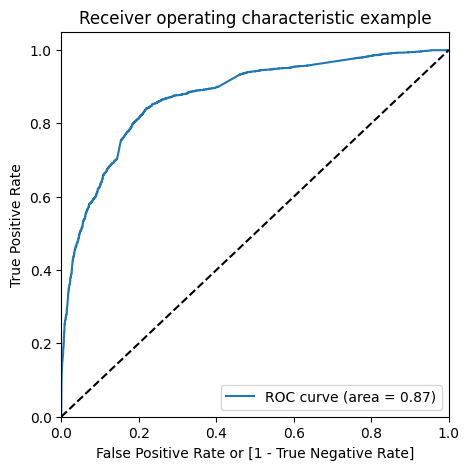

In [62]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)


The area under the curve of the ROC is 0.87 indicates a good model. 


<b>Sensitivity and specificity tradeoff to find the optimal cutoff point.</b>


In [63]:
#numbers = [float(x)/10 for x in range(10)]
numbers = [0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9]

for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,ProspectID,Predicted,0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.782856,9044,1,1,1,1,1,1,1,1,1,1,1,0,0
1,1,0.964252,3022,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.205338,6232,0,1,1,1,0,0,0,0,0,0,0,0,0
3,1,0.213871,309,0,1,1,1,0,0,0,0,0,0,0,0,0
4,0,0.469510,3833,0,1,1,1,1,1,1,1,0,0,0,0,0


In [64]:
# Let's create a dataframe to see the values of accuracy, sensitivity, and specificity at 
# different values of probabiity cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

        prob  accuracy     sensi     speci
0.000  0.000  0.384603  1.000000  0.000000
0.100  0.100  0.517203  0.979167  0.228491
0.200  0.200  0.755695  0.880719  0.677559
0.300  0.300  0.800314  0.843954  0.773041
0.350  0.350  0.804870  0.821078  0.794741
0.375  0.375  0.808013  0.804739  0.810059
0.400  0.400  0.808013  0.790441  0.818994
0.500  0.500  0.800786  0.667892  0.883840
0.600  0.600  0.792930  0.583333  0.923921
0.700  0.700  0.778947  0.502042  0.952004
0.800  0.800  0.751767  0.397876  0.972938
0.900  0.900  0.708877  0.258578  0.990299


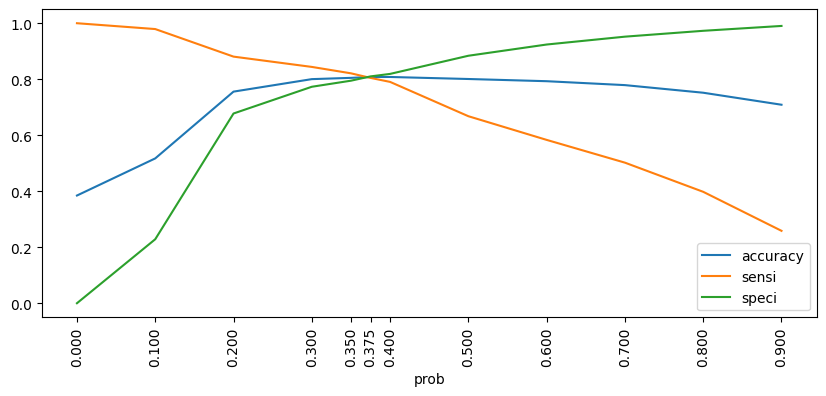

In [65]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'],xticks=cutoff_df['prob'],figsize=(10,4))
plt.xticks(rotation=90)

plt.show()

In [66]:
optimal_cut_off=0.36

In [67]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > optimal_cut_off else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,ProspectID,Predicted,0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.782856,9044,1,1,1,1,1,1,1,1,1,1,1,0,0,1
1,1,0.964252,3022,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.205338,6232,0,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0.213871,309,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0.469510,3833,0,1,1,1,1,1,1,1,0,0,0,0,0,1


In [68]:
#Accuracy 

metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)


0.8054988216810683

In [69]:
#RecheckConfusion MAtrix
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion2)

[[3462  455]
 [ 813 1635]]


In [70]:
TP2 = confusion2[1,1] # true positive 
TN2 = confusion2[0,0] # true negatives
FP2 = confusion2[0,1] # false positives
FN2 = confusion2[1,0] # false negatives
metric_sensitivity=TP2/(TP2+FN2)
metric_specificity=TN2/(TN2+FP2)
print("metric_sensitivity",metric_sensitivity)
print("metric_specificity",metric_specificity)

metric_sensitivity 0.6678921568627451
metric_specificity 0.8838396732193005


In [71]:
y_train_pred_final

,Converted,Conversion_Prob,ProspectID,Predicted,0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.782856,9044,1,1,1,1,1,1,1,1,1,1,1,0,0,1
1,1,0.964252,3022,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.205338,6232,0,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0.213871,309,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0.469510,3833,0,1,1,1,1,1,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,0,0.221574,367,0,1,1,1,0,0,0,0,0,0,0,0,0,0
6361,1,0.661724,82,1,1,1,1,1,1,1,1,1,1,0,0,0,1
6362,0,0.036028,8182,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6363,1,0.454983,7064,0,1,1,1,1,1,1,1,0,0,0,0,0,1


<h4>Step 7: Making Predictions on the Test Set</h4>


In [72]:
lstColumns=['Total_Visits', 'Website_Time_Spent', 'PVPV']
X_test[lstColumns] =scaler_minmax.transform(X_test[lstColumns])

In [73]:
# Select the columns in X_train for X_test as well
cols_X_train=X_train.columns

X_test = X_test[cols_X_train]
X_test.head()

,Do_Not_Email,Total_Visits,Website_Time_Spent,PVPV,LD_ORIGIN_Lead Add Form,OCCU_Working Professional,LST_NTB_ACT_Email Link Clicked,LST_NTB_ACT_Email Opened,LST_NTB_ACT_Modified,LST_NTB_ACT_Olark Chat Conversation,LST_NTB_ACT_Page Visited on Website,LST_ACT_Converted to Lead,LST_ACT_Email Bounced,LD_SRC_Welingak Website
6297,0,0.28125,0.454665,0.5625,0,0,0,0,0,0,0,0,0,0
8181,0,0.00000,0.000000,0.0000,1,0,0,0,0,0,0,0,0,0
7000,0,0.00000,0.000000,0.0000,0,0,0,0,1,0,0,0,0,0
8052,0,0.00000,0.000000,0.0000,1,1,0,0,0,0,0,0,0,0
2917,0,0.00000,0.000000,0.0000,0,0,0,0,1,0,0,0,0,0


In [74]:
X_test_sm = sm.add_constant(X_test[cols_X_train])
X_test_sm



,const,Do_Not_Email,Total_Visits,Website_Time_Spent,PVPV,LD_ORIGIN_Lead Add Form,OCCU_Working Professional,LST_NTB_ACT_Email Link Clicked,LST_NTB_ACT_Email Opened,LST_NTB_ACT_Modified,LST_NTB_ACT_Olark Chat Conversation,LST_NTB_ACT_Page Visited on Website,LST_ACT_Converted to Lead,LST_ACT_Email Bounced,LD_SRC_Welingak Website
6297,1.0,0,0.28125,0.454665,0.5625,0,0,0,0,0,0,0,0,0,0
8181,1.0,0,0.00000,0.000000,0.0000,1,0,0,0,0,0,0,0,0,0
7000,1.0,0,0.00000,0.000000,0.0000,0,0,0,0,1,0,0,0,0,0
8052,1.0,0,0.00000,0.000000,0.0000,1,1,0,0,0,0,0,0,0,0
2917,1.0,0,0.00000,0.000000,0.0000,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,1.0,0,0.09375,0.163732,0.1875,0,0,0,1,0,0,0,0,0,0
7956,1.0,0,0.00000,0.000000,0.0000,0,0,1,0,0,0,0,0,0,0
8002,1.0,1,0.25000,0.152289,0.5000,0,0,0,0,0,0,0,0,0,0
1963,1.0,0,0.06250,0.115317,0.1250,0,0,0,1,0,0,0,0,0,0


In [75]:
#Predicting y_test based on X_test
y_test_pred = res.predict(sm.add_constant(X_test))
y_test_pred[:10]


6297    0.653632
8181    0.964252
7000    0.104566
8052    0.997688
2917    0.104566
2723    0.428142
9072    0.216996
5420    0.013237
7045    0.997047
4082    0.055956
dtype: float64

In [76]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()


,0
6297,0.653632
8181,0.964252
7000,0.104566
8052,0.997688
2917,0.104566


In [77]:
#creating the dataframe with "ProspectID" for future cross reference
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final['ProspectID'] = y_test_pred.index
y_pred_final.head()



,Converted,Conversion_Prob,ProspectID
0,1,0.653632,6297
1,0,0.964252,8181
2,0,0.104566,7000
3,1,0.997688,8052
4,0,0.104566,2917


In [78]:
#calculating the final_predicted basis the optimal_cut_off value arrived above:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > optimal_cut_off else 0)
y_pred_final.head()


,Converted,Conversion_Prob,ProspectID,final_predicted
0,1,0.653632,6297,1
1,0,0.964252,8181,1
2,0,0.104566,7000,0
3,1,0.997688,8052,1
4,0,0.104566,2917,0


In [79]:
#calculate the accuracy
metrics.accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)


0.8035190615835777

In [80]:
confusion3 = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion3

array([[1388,  329],
       [ 207,  804]], dtype=int64)

In [81]:
#calculating the sensitivity and specificity again
TP3 = confusion3[1,1] # true positive 
TN3 = confusion3[0,0] # true negatives
FP3 = confusion3[0,1] # false positives
FN3 = confusion3[1,0] # false negatives

sensitivity=TP3 / float(TP3+FN3)
specificity=TN3 / float(TN3+FP3)

print("sensitivity",sensitivity)
print("specificity",specificity)



sensitivity 0.7952522255192879
specificity 0.8083867210250437


<h4>Precision-Recall View</h4>

In [82]:
#building the confusion matrix
confusion4 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion4

array([[3462,  455],
       [ 813, 1635]], dtype=int64)

In [83]:
#calculating the Precision and recall value
TP4 = confusion3[1,1] # true positive 
TN4 = confusion3[0,0] # true negatives
FP4 = confusion3[0,1] # false positives
FN4 = confusion3[1,0] # false negatives

_precision=TP4/(TP4+FP4)
_recall=TP4/(TP4+FN4)

print("_precision",_precision)
print("_recall",_recall)

_precision 0.7096204766107679
_recall 0.7952522255192879


<h4>Precision and recall tradeoff</h4>


In [84]:
from sklearn.metrics import precision_recall_curve


In [85]:
#y_train_pred_final.Converted, y_train_pred_final.Predicted
y_train_pred_final.head()


,Converted,Conversion_Prob,ProspectID,Predicted,0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.782856,9044,1,1,1,1,1,1,1,1,1,1,1,0,0,1
1,1,0.964252,3022,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.205338,6232,0,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0.213871,309,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0.469510,3833,0,1,1,1,1,1,1,1,0,0,0,0,0,1


In [86]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)


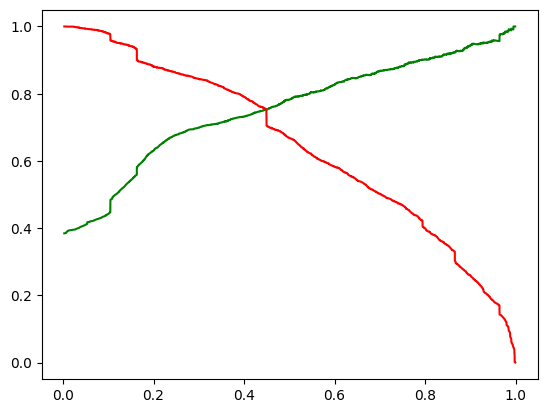

In [87]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()


In [88]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.45 else 0)

y_train_pred_final.head()


,Converted,Conversion_Prob,ProspectID,Predicted,0.0,0.1,0.2,0.3,0.35,0.375,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.782856,9044,1,1,1,1,1,1,1,1,1,1,1,0,0,1
1,1,0.964252,3022,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.205338,6232,0,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0.213871,309,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0.469510,3833,0,1,1,1,1,1,1,1,0,0,0,0,0,1


In [89]:
#checked the accuracy
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)


0.7974862529457973

In [90]:
confusion5 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion5

array([[3351,  566],
       [ 723, 1725]], dtype=int64)

In [91]:
TP5 = confusion5[1,1] # true positive 
TN5 = confusion5[0,0] # true negatives
FP5 = confusion5[0,1] # false positives
FN5 = confusion5[1,0] # false negatives

print("precision",TP5/(TP5+FP5))
print("recall",TP5/(TP5+FN5))




precision 0.7529463116542995
recall 0.7046568627450981


<h4>Step 4: Making Predictions on the Test Set</h4>


In [92]:
y_test_pred = res.predict(sm.add_constant(X_test))
y_test_pred[:10]


6297    0.653632
8181    0.964252
7000    0.104566
8052    0.997688
2917    0.104566
2723    0.428142
9072    0.216996
5420    0.013237
7045    0.997047
4082    0.055956
dtype: float64

In [93]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()


,0
6297,0.653632
8181,0.964252
7000,0.104566
8052,0.997688
2917,0.104566


In [94]:
#creating the dataframe with "ProspectID" for future reference
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final['ProspectID'] = y_test_pred.index
y_pred_final.head()
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final.head()



,Converted,Conversion_Prob,ProspectID
0,1,0.653632,6297
1,0,0.964252,8181
2,0,0.104566,7000
3,1,0.997688,8052
4,0,0.104566,2917


In [95]:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.44 else 0)
y_pred_final.head()


,Converted,Conversion_Prob,ProspectID,final_predicted
0,1,0.653632,6297,1
1,0,0.964252,8181,1
2,0,0.104566,7000,0
3,1,0.997688,8052,1
4,0,0.104566,2917,0


In [96]:
#checking accuracy
accuracy=metrics.accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)
print("accuracy=",accuracy)

accuracy= 0.8046187683284457


<b>Checking Precision and Recall for final predicted y.</b>

In [97]:
confusion6 = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion6

array([[1453,  264],
       [ 269,  742]], dtype=int64)

In [98]:
TP6 = confusion6[1,1] # true positive 
TN6 = confusion6[0,0] # true negatives
FP6 = confusion6[0,1] # false positives
FN6 = confusion6[1,0] # false negatives
print("precision",TP6/(TP6+FP6))
print("recall",TP6/(TP6+FN6))


precision 0.7375745526838966
recall 0.7339268051434223


In [99]:
#y_pred_final.to_csv('y_pred_final_precision_recall.csv')

In [100]:
y_pred_final

,Converted,Conversion_Prob,ProspectID,final_predicted
0,1,0.653632,6297,1
1,0,0.964252,8181,1
2,0,0.104566,7000,0
3,1,0.997688,8052,1
4,0,0.104566,2917,0
...,...,...,...,...
2723,0,0.213276,7397,0
2724,0,0.108946,7956,0
2725,1,0.129048,8002,0
2726,0,0.199438,1963,0


<b>Merge X_test and y_pred to see if the final metrics arrived is making sense and use for Analysis</b>

In [101]:
y_pred_final=y_pred_final.rename({'ProspectID':'ProspectID_y'},axis=1)
y_pred_final

,Converted,Conversion_Prob,ProspectID_y,final_predicted
0,1,0.653632,6297,1
1,0,0.964252,8181,1
2,0,0.104566,7000,0
3,1,0.997688,8052,1
4,0,0.104566,2917,0
...,...,...,...,...
2723,0,0.213276,7397,0
2724,0,0.108946,7956,0
2725,1,0.129048,8002,0
2726,0,0.199438,1963,0


In [102]:
X_test['ProspectID_X']=X_test.index

In [103]:
dfAnalysis=X_test.merge(y_pred_final, how="inner",left_on="ProspectID_X",right_on="ProspectID_y")
dfAnalysis.to_csv('dfAnalysis.csv')

<b>[End of File]</b>